In [24]:
import os 
file = ['R101.txt', 'R103.txt', 'R102.txt', 'R112.txt', 'R106.txt', 'R107.txt', 'R105.txt', 'R111.txt', 'C108.txt', 
 'RC208.txt', 'C109.txt', 'R110.txt', 'R104.txt', 'R201.txt', 'R202.txt', 'R203.txt', 'R207.txt', 'R206.txt',
'R210.txt', 'R204.txt', 'C208.txt', 'R205.txt', 'R211.txt', 'RC108.txt', 'RC105.txt', 'R208.txt', 'C205.txt',
'C204.txt', 'R209.txt', 'RC104.txt', 'RC106.txt', 'C206.txt', 'C207.txt', 'RC107.txt', 'RC103.txt', 'C203.txt', 
'C202.txt', 'RC102.txt', 'C201.txt', 'RC101.txt', 'R109.txt', 'C104.txt', 'RC204.txt', 'RC205.txt', 'C105.txt',
'R108.txt', 'C107.txt', 'RC207.txt', 'RC206.txt', 'C106.txt', 'C102.txt', 'RC202.txt', 'RC203.txt', 'C103.txt',
'C101.txt', 'RC201.txt']

idx = 0 
assert idx < len(file)
with open('Data.txt', 'w') as outfile:
    file_path = 'txt/' + file[idx]
    with open(file_path) as infile:
        for line in infile:
            outfile.write(line)

In [25]:
import torch
from torch.distributions import Categorical
import random
import itertools
import numpy as np
import copy
import torch
from torch import nn
from torch.nn import functional as F
from copy import deepcopy
import math 
import numpy as np
from Model.Config import *
from Model.AMO import * 
from Ant_k_starts import *
from Normalize_data import *
from Ant import *
from Injection import *
from Cross_Exchange import *
from Local_search import * 
from Draw import *


In [26]:
device = None
cfg = Data_100()
options = 2
EPS = 1e-10
model = Net3().to(device)
model.load_state_dict(torch.load('AMO-ACO-100-No-Start.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [27]:
pyg_data_normalize = normalize_data(cfg)
heuristic_measure, log, topk = model(pyg_data_normalize)
heuristic_measure = heuristic_measure.reshape((cfg.graph_size+1, cfg.graph_size+1))

In [28]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

data = torch.tensor([[float(x) for x in y] for y in data])
tsp_coordinates = data[:, 1:3] 
demands = torch.tensor(demand, dtype = torch.float32)
time_window = data[:, 4:]
durations = time_window[:, -1] 
distances = gen_distance_matrix(tsp_coordinates, device = device)

aco = ACO(distances, demands, time_window, 10, topk, max_cap, options=options, heuristic=heuristic_measure, n_ants=cfg.n_ants)

In [29]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

CAP=max_cap
colony=Ant(data,CAP,0.7, heuristic_measure)
colony.customer_cord()
colony.euclidean_distance()
colony.width_window()
_ = colony.path_pheromon()

In [30]:
def convert_dict(path): # path: tensor depot 0(m,)
    path += 1
    path = path.to(torch.long)
    zero_indices = torch.where(path == 1)[0]
    zero_indices = zero_indices.tolist()
    path = path.tolist()
    while zero_indices[-1] - zero_indices[-2] == 1:
        zero_indices.pop()
    dict = {}
    for i in range(len(zero_indices) - 1):
        dict[i] = path[zero_indices[i]: zero_indices[i+1] + 1 ]
    return dict

In [31]:
def update_btnt(path, cost, pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost):
    '''
    path: Loi giai tiem nang
    cost: ham cost cua loi giai
    pheromone: aco.pheromone
    effort: so iter truoc khi ket thuc
    '''
    if cost < best_cost:
        reward = int(k_candidate * prob_to_update * reward_coff) * effort
    else:
        reward = int(k_candidate * prob_to_update) * effort
    for route in path.values(): # route
        for l in range(len(route) - 1):
            pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += reward/cost
    reward_coff += 2
    return reward_coff, pheromone
    

In [32]:
import time
max_iteration = cfg.epochs 
n_customer = len(data)
k_candidate = 100
prob_to_update = 0.05
best = 1e10
best_cost = 1e10
aco.decay = 1
aco.beta = 0.5
elitism_set = 0
reward_coff = 2
effort = 0
final_path = 0
prob_to_destroy = 0.05
cnt = 0
counter = 0
best_data = []
best_cost_data = []
destroy_data = []
t1 = time.time()


def save_solution(ants_route, travel_distance, BTNT, max_route, max_travel):
    if len(ants_route.keys()) < max_route:
        BTNT[-1] = ants_route
        max_travel = travel_distance
        max_route = len(ants_route.keys())
    elif len(ants_route.keys()) == max_route and travel_distance < max_travel:
        BTNT[-1] = ants_route
        max_travel = travel_distance
        max_route = len(ants_route.keys())
    return BTNT, max_travel, max_route


BTNT = [0]
max_travel = 1e10

max_route = int(n_customer)
for k in range(max_iteration):

    paths, costs = aco.run()
    local_path = []
    candidate_values, indexs = torch.topk(costs, k = k_candidate, largest=False)
    candidate_path = paths.T[indexs] # (k * prob_size)
    for i, (value, path) in enumerate(zip(candidate_values, candidate_path)):
        ants_route = convert_dict(path)
        if torch.rand(1) < prob_to_update:
            travel_distance, ants_route = injection(ants_route, colony, 0.5)
            travel_distance, ants_route = cross_exchange(ants_route, colony)
            travel_distance, ants_route = ls_1route(ants_route, colony)
            travel_distance, ants_route = ls3(ants_route)
            BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
            candidate_values[i] = travel_distance
        local_path.append(ants_route)
    
    aco.pheromone *= aco.decay
    value_to_update, index_to_update = torch.topk(candidate_values, k = int(k_candidate * prob_to_update), largest=False)
    for i, j in enumerate(index_to_update):
        path = local_path[j] # dict
        for route in path.values(): # route
            for l in range(len(route) - 1):
                if i == 0:
                    aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
                aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
    if torch.min(candidate_values) < best:
        best = torch.min(candidate_values)
        best_path = local_path[index_to_update[0]]
        if k > 0 and elitism_set != 0:
            path, cost = elitism_set
            reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
            aco.pheromone = pheromone 
        elitism_set = (best_path, best)  # tuple (path, cost)
        effort = 1
        tries = 0
    
    # Alimentation:
    if tries == 3 and elitism_set != 0:
        tries = 0
        path, cost = elitism_set
        reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
        elitism_set = 0
        aco.pheromone = pheromone 

    
    if elitism_set == 0:
        counter += 1

    
    if elitism_set != 0:
        counter = 0
        ants_route, cost = elitism_set
        for _ in range(1):
            travel_distance, ants_route = injection(ants_route, colony, 0.5)
        for _ in range(1):
            travel_distance, ants_route = cross_exchange(ants_route, colony)
        travel_distance, ants_route = local_search(ants_route, colony, n_customer, cfg.q)
        travel_distance, ants_route = ls3(ants_route)
        for _ in range(50):
            travel_distance, ants_route = ls_1route(ants_route, colony)
        BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
        if travel_distance < cost:
           elitism_set = (ants_route, travel_distance)
           effort += 1
        if travel_distance < best_cost:
            best_cost = travel_distance 
            final_path = ants_route
        else:
           effort += 1
           tries += 1
    
    if elitism_set == 0 and counter > prob_to_destroy * max_iteration:
        print(destroy)
        travel_distance, ants_route = destroy(final_path, colony, 0.5)
        travel_distance, ants_route = destroy_ls_1route(final_path, colony)
        r = np.random.random()
        if r < 0.5:
            travel_distance, ants_route = ls1(final_path)
        else:
            travel_distance, ants_route = ls2(final_path)
        print("Destroy: ", travel_distance)
        elitism_set = (ants_route, travel_distance)
        counter = 0
        destroy_data.append(k)




    best_data.append(best)
    best_cost_data.append(best_cost)
    print('epoch {}: Best: {}, Alimentation: {}'.format(k, best, best_cost))
t2 = time.time()
time_run = t2-t1



epoch 0: Best: 2486.66943359375, Alimentation: 2037.4509844688034
epoch 1: Best: 2315.43896484375, Alimentation: 1864.2757143333863
epoch 2: Best: 2238.440673828125, Alimentation: 1864.2757143333863
epoch 3: Best: 2137.18408203125, Alimentation: 1864.2757143333863
epoch 4: Best: 2068.82470703125, Alimentation: 1864.2757143333863
epoch 5: Best: 2068.82470703125, Alimentation: 1864.2757143333863
epoch 6: Best: 2068.82470703125, Alimentation: 1855.4543322095944
epoch 7: Best: 2068.82470703125, Alimentation: 1840.7369598944988
epoch 8: Best: 2068.82470703125, Alimentation: 1810.9929712119492
epoch 9: Best: 2068.82470703125, Alimentation: 1807.6290703206105
epoch 10: Best: 2068.82470703125, Alimentation: 1807.5826261480108
epoch 11: Best: 2068.82470703125, Alimentation: 1807.5826261480106
epoch 12: Best: 2068.82470703125, Alimentation: 1807.5826261480106
epoch 13: Best: 2068.82470703125, Alimentation: 1807.5826261480106
epoch 14: Best: 2068.82470703125, Alimentation: 1807.5826261480106
epoc

KeyboardInterrupt: 

Optional

In [ ]:
for _ in range(10):
    ants_route, cost = BTNT[-1], max_travel
    for _ in range(1):
        travel_distance, ants_route = injection(ants_route, colony, 0.5)
    for _ in range(1):
        travel_distance, ants_route = cross_exchange(ants_route, colony)
    travel_distance, ants_route = local_search(ants_route, colony, n_customer, cfg.q)
    travel_distance, ants_route = ls3(ants_route)
    for _ in range(50):
        travel_distance, ants_route = ls_1route(ants_route, colony)
    BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
    print(max_travel, max_route)

854.9071978115635 4
854.9071978115635 4
854.9071978115635 4
854.9071978115635 4
854.9071978115635 4
854.9071978115635 4
854.9071978115635 4
837.9265978573876 4
837.9265978573875 4
837.9265978573875 4


In [ ]:
# final_solution = max(1000*max_route + max_travel, 1000*len(final_path.keys()) + best_cost)
# final_solution
if 1000*max_route + max_travel > 1000*len(final_path.keys()) + best_cost:
    final_route = final_path
    final_cost = best_cost
    final_vehicle = len(final_path.keys())
else:
    final_route = BTNT[-1]
    final_cost = max_travel
    final_vehicle = max_route

In [ ]:
with open('Data.txt', 'r') as f:
    name = f.readline()
name.rstrip()

def change_2_save(index, route):
    ans = "Route #{}:".format(index)
    for node in route[1:-1]:
        ans += " " + str(node-1)
    return ans 

with open('Solution.txt', 'a') as f:
    f.write(name + '\n')
    for id, i in enumerate(final_route.values()):
        f.write(change_2_save(id+1, i) + '\n')
    f.write("Time: {}".format(round(time_run,2)) + '\n')
    f.write("Vehicle: {}".format(final_vehicle)+ '\n')
    f.write("Distance: {}".format(final_cost)+ '\n')
    f.write("-----------------------------------------------"+ '\n')

    



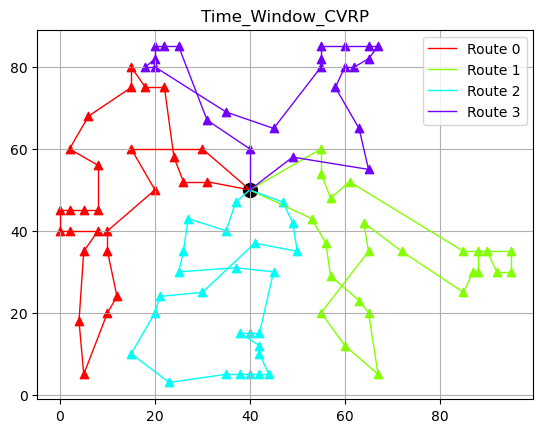

In [ ]:
draw(final_route, colony)